# Import liabraries

In [ ]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 16.0MB/s 


In [ ]:
pip install split-folders


In [ ]:

import os 
import splitfolders 
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import random

from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import xception

# Image Preprocessing

In [ ]:
# Dowload the dataset
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip > /dev/null

--2021-04-18 12:30:23--  http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.120.116
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.120.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305323328 (291M) [application/zip]
Saving to: ‘ut-zap50k-images.zip’

ut-zap50k-images.zi 100%[===================>] 291.18M  70.6MB/s    in 4.3s    

2021-04-18 12:30:27 (67.6 MB/s) - ‘ut-zap50k-images.zip’ saved [305323328/305323328]



In [ ]:
import os
dir_name = "./data"
isDir = os.path.isdir(dir_name) 
if not isDir:
    !mkdir data
    !mkdir data/Boots data/Sandals data/Shoes data/Slippers
    !find ut-zap50k-images/Boots -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Boots;
    !find ut-zap50k-images/Sandals -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Sandals;
    !find ut-zap50k-images/Shoes -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Shoes;
    !find ut-zap50k-images/Slippers -type f -print0 | xargs -0 mv -t data/Slippers;
    !rm -rf ut-zap50k-images;

In [ ]:
# pip install split-folders

# split dataset into train (2000), test(1000) and validation (1000)
splitfolders.ratio('data', output="splitted_data", seed=1337, ratio=(.8, 0.1, 0.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 776 files [00:00, 7751.78 files/s]
Copying files: 1623 files [00:00, 7949.92 files/s]
Copying files: 2564 files [00:00, 8336.65 files/s]
Copying files: 3402 files [00:00, 8348.74 files/s]
Copying files: 4480 files [00:00, 8953.77 files/s]
Copying files: 5783 files [00:00, 8377.20 files/s]


In [ ]:
dir_name = "./data"

files='**/*.jpg'
filenames = glob(os.path.join(dir_name, files))
classes = [os.path.basename(os.path.dirname(name)) for name in filenames]
count = list(Counter(classes).items())
print("Class count:", count);

Class count: [('Shoes', 1500), ('Sandals', 1500), ('Boots', 1500), ('Slippers', 1283)]


In [ ]:
class_names = os.listdir(dir_name) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels
print("Classes:", class_name2id)

labels = [class_name2id[c] for c in classes]
Counter(labels)

Classes: {'Shoes': 0, 'Sandals': 1, 'Boots': 2, 'Slippers': 3}


Counter({0: 1500, 1: 1500, 2: 1500, 3: 1283})

# Create The dataset for TF

In [ ]:
image_size = (102, 136) 
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "splitted_data/train",
    labels = 'inferred',
    label_mode='int',
    # validation_split=0.2,
    # subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "splitted_data/val",
    labels = 'inferred',
    label_mode='int',
    # validation_split=None,
    # subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "splitted_data/test",
    labels = 'inferred',
    label_mode='int',
    # validation_split=None,
    # subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4626 files belonging to 4 classes.
Found 578 files belonging to 4 classes.
Found 579 files belonging to 4 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds1 = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds1 = train_ds1.map(lambda x, y: (norm_layer(x), y))   #  pixels values be in '[0,1]'

val_ds1 = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds1.map(lambda x, y: (norm_layer(x), y))      

test_ds1 = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds1 = test_ds1.map(lambda x, y: (norm_layer(x), y))      

# SIAMESE NETWORK


In [ ]:
input = tf.keras.layers.Input(shape=image_size+(3,))
x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2, 2), padding='same', activation='relu')(input)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
embeddings = tf.keras.layers.Dense(512, activation=None)(x) # No activation on final dense layer
distance = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embeddings) # L2 normalize embeddings

siamese_model = tf.keras.models.Model(inputs=input, outputs=distance)

In [ ]:
siamese_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 102, 136, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 68, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 34, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 34, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 17, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 8, 128)         0     

# Train the model

In [ ]:
# Compile the model
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss())


In [ ]:
import time
start_time = time.time()

# Train the network
history = siamese_model.fit(
    train_ds1,
    epochs=10,
    validation_data=(val_ds1), 
    # callbacks=[tbCallBack])
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/10
290/290 [==============================] - 36s 10ms/step - loss: 1.0075 - val_loss: 0.9745
Epoch 2/10
290/290 [==============================] - 2s 7ms/step - loss: 0.8775 - val_loss: 0.8157
Epoch 3/10
290/290 [==============================] - 2s 8ms/step - loss: 0.8225 - val_loss: 0.8301
Epoch 4/10
290/290 [==============================] - 2s 8ms/step - loss: 0.8006 - val_loss: 0.9562
Epoch 5/10
290/290 [==============================] - 2s 7ms/step - loss: 0.8282 - val_loss: 0.8270
Epoch 6/10
290/290 [==============================] - 2s 7ms/step - loss: 0.7916 - val_loss: 0.8082
Epoch 7/10
290/290 [==============================] - 2s 7ms/step - loss: 0.7884 - val_loss: 0.8283
Epoch 8/10
290/290 [==============================] - 2s 7ms/step - loss: 0.8014 - val_loss: 0.8287
Epoch 9/10
290/290 [==============================] - 2s 7ms/step - loss: 0.7744 - val_loss: 0.8176
Epoch 10/10
290/290 [==============================] - 2s 7ms/step - loss: 0.7650 - val_loss: 0.79

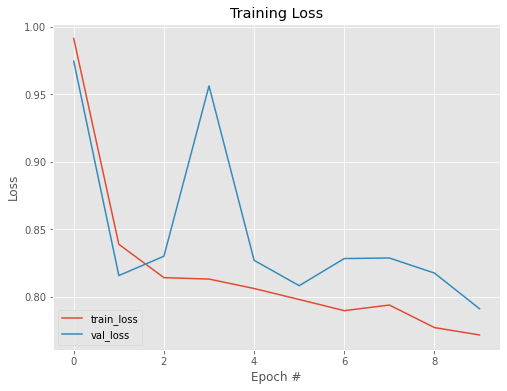

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
# Evaluate the network
results = siamese_model.predict(test_ds1)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_ds1):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature extraction

In [ ]:
train_results = siamese_model.predict(train_ds1)
val_results = siamese_model.predict(val_ds1)
test_results = siamese_model.predict(test_ds1)


In [ ]:
y_train = np.concatenate([y for x, y in train_ds1], axis=0)
y_test = np.concatenate([y for x, y in test_ds1], axis=0)
y_val = np.concatenate([y for x, y in val_ds1], axis=0)
y_train[0]

2

# Single layer classifier

In [ ]:
class_model = tf.keras.Sequential(name="class_model")
# class_model.add(tf.keras.layers.Dense(128, activation='relu', name="dense_layer1"))
class_model.add(tf.keras.layers.Dense(4, activation='softmax', name="predictions"))

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
import time

class_model.compile(optimizer=Adam(lr=0.001), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"]
                    )

start_time = time.time()

history = class_model.fit(x=val_results, y= y_val, 
                          epochs=50, 
                          validation_data=(val_results, y_val),
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/50
19/19 [==============================] - 0s 11ms/step - loss: 1.3553 - accuracy: 0.3239 - val_loss: 1.1977 - val_accuracy: 0.4931
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 1.1576 - accuracy: 0.5959 - val_loss: 1.0550 - val_accuracy: 0.6332
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 1.0391 - accuracy: 0.5725 - val_loss: 0.9703 - val_accuracy: 0.6730
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.9721 - accuracy: 0.6772 - val_loss: 0.9118 - val_accuracy: 0.7266
Epoch 5/50
19/19 [==============================] - 0s 6ms/step - loss: 0.9041 - accuracy: 0.7475 - val_loss: 0.8706 - val_accuracy: 0.7422
Epoch 6/50
19/19 [==============================] - 0s 6ms/step - loss: 0.8677 - accuracy: 0.7558 - val_loss: 0.8388 - val_accuracy: 0.7595
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.8376 - accuracy: 0.7653 - val_loss: 0.8119 - val_accuracy: 0.7612
Epoch 8/50
19/19 [=

In [ ]:
class_model.summary()

Model: "class_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
predictions (Dense)          (None, 4)                 2052      
Total params: 2,052
Trainable params: 2,052
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [ ]:
from sklearn.metrics import classification_report

y_pred = class_model.predict(test_results)
# calculate classification accuracy
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

       Shoes     0.9739    0.9933    0.9835       150
     Sandals     0.8509    0.9133    0.8810       150
       Boots     0.9114    0.9600    0.9351       150
    Slippers     0.9065    0.7519    0.8220       129

    accuracy                         0.9102       579
   macro avg     0.9107    0.9047    0.9054       579
weighted avg     0.9108    0.9102    0.9084       579



# TRANSFER LEARNING + SIAMESE NETWORK


In [ ]:
base_cnn = xception.Xception(weights="imagenet", input_shape=image_size+(3,), include_top=False)

g_a_b = tf.keras.layers.GlobalAveragePooling2D()(base_cnn.output)
dense1 = tf.keras.layers.Dense(1024, activation="relu")(g_a_b)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
embeddings = tf.keras.layers.Dense(512)(dense1)

distance = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embeddings) # L2 normalize embeddings

siamese_model = tf.keras.models.Model(inputs = base_cnn.input, outputs = distance, name="distance")

for layer in base_cnn.layers:
    layer.trainable = False

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
siamese_model.summary()

Model: "distance"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 102, 136, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 50, 67, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 50, 67, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 50, 67, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

# Train the model

In [ ]:
# Compile the model
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss())


In [ ]:
import time
start_time = time.time()

# Train the network
history = siamese_model.fit(
    train_ds1,
    epochs=10,
    validation_data=(val_ds1), 
    # callbacks=[tbCallBack])
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/10
290/290 [==============================] - 44s 29ms/step - loss: 0.7151 - val_loss: 0.5862
Epoch 2/10
290/290 [==============================] - 7s 25ms/step - loss: 0.3756 - val_loss: 0.5626
Epoch 3/10
290/290 [==============================] - 7s 25ms/step - loss: 0.2802 - val_loss: 0.5965
Epoch 4/10
290/290 [==============================] - 7s 26ms/step - loss: 0.2081 - val_loss: 0.4407
Epoch 5/10
290/290 [==============================] - 7s 26ms/step - loss: 0.1682 - val_loss: 0.4343
Epoch 6/10
290/290 [==============================] - 7s 26ms/step - loss: 0.1372 - val_loss: 0.4345
Epoch 7/10
290/290 [==============================] - 7s 26ms/step - loss: 0.1095 - val_loss: 0.4282
Epoch 8/10
290/290 [==============================] - 7s 26ms/step - loss: 0.0889 - val_loss: 0.4180
Epoch 9/10
290/290 [==============================] - 8s 26ms/step - loss: 0.0577 - val_loss: 0.4556
Epoch 10/10
290/290 [==============================] - 7s 26ms/step - loss: 0.0733 - val_l

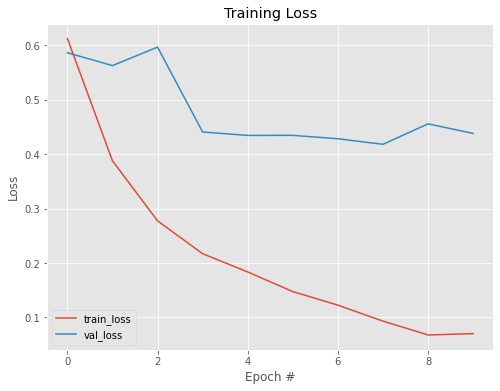

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
# Evaluate the network
results = siamese_model.predict(test_ds1)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_ds1):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature extraction

In [ ]:
train_results = siamese_model.predict(train_ds1)
val_results = siamese_model.predict(val_ds1)
test_results = siamese_model.predict(test_ds1)


In [ ]:
y_train = np.concatenate([y for x, y in train_ds1], axis=0)
y_test = np.concatenate([y for x, y in test_ds1], axis=0)
y_val = np.concatenate([y for x, y in val_ds1], axis=0)
y_train[0]

0

# Single layer classifier

In [ ]:
class_model = tf.keras.Sequential(name="class_model")
# class_model.add(tf.keras.layers.Dense(128, activation='relu', name="dense_layer1"))
class_model.add(tf.keras.layers.Dense(4, activation='softmax', name="predictions"))

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
import time

class_model.compile(optimizer=Adam(lr=0.001), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"]
                    )

start_time = time.time()

history = class_model.fit(x=val_results, y= y_val, 
                          epochs=50, 
                          validation_data=(val_results, y_val),
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/50
19/19 [==============================] - 0s 12ms/step - loss: 1.3368 - accuracy: 0.4772 - val_loss: 1.1115 - val_accuracy: 0.9273
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 1.0455 - accuracy: 0.9329 - val_loss: 0.8739 - val_accuracy: 0.9446
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.8268 - accuracy: 0.9482 - val_loss: 0.6935 - val_accuracy: 0.9429
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.6468 - accuracy: 0.9491 - val_loss: 0.5601 - val_accuracy: 0.9464
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5387 - accuracy: 0.9384 - val_loss: 0.4667 - val_accuracy: 0.9481
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.4504 - accuracy: 0.9488 - val_loss: 0.3983 - val_accuracy: 0.9481
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.3841 - accuracy: 0.9530 - val_loss: 0.3491 - val_accuracy: 0.9481
Epoch 8/50
19/19 [=

In [ ]:
class_model.summary()

Model: "class_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
predictions (Dense)          (None, 4)                 2052      
Total params: 2,052
Trainable params: 2,052
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [ ]:
from sklearn.metrics import classification_report

y_pred = class_model.predict(test_results)
# calculate classification accuracy
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

       Shoes     0.9739    0.9933    0.9835       150
     Sandals     0.9595    0.9467    0.9530       150
       Boots     0.9610    0.9867    0.9737       150
    Slippers     0.9355    0.8992    0.9170       129

    accuracy                         0.9585       579
   macro avg     0.9575    0.9565    0.9568       579
weighted avg     0.9583    0.9585    0.9582       579

